# Использование бутстрапа в оценке стоимости на примере разработки элементов кредитной политики небольшого банка

Cyrill A. Murashev, 2023-03-07

## Введение

Данный материал является продолжением цикла работ на тему методов повторной выборки. В [предыдущей статье](https://github.com/Kirill-Murashev/AI_for_valuers_book/blob/main/Parts-Chapters/Jackknife/jackknife-nov.ipynb) мы рассмотрели метод jackknife. Сегодня мы рассмотрим более популярный и универсальный метод бутстрапа. Не будет преувеличением сказать, что бутстрап является одним из краеугольных камней современной науки о данных, наряду, например, с линейной регрессией или ROC-анализом. Данный материал был разработан специально для оценщиков, поэтому мы рассмотрим тему с точки зрения её практического применения в практике залогового кредитования.

Представим себе небольшой банк, работающий в Восточной Европе. Его руководство поставило перед собой цель разработать систему правил кредитной политики банка. Одно из них должно решить задачу определения максимальной цены залогового имущества, безопасной для финансовой устойчивости банка. При этом было решено учесть современные реалии, особенно последние достижения в мире искусственного интеллекта, а также требования [МСФО 13 "Оценка справедливой стоимости"](https://www.ifrs.org/issued-standards/list-of-standards/ifrs-13-fair-value-measurement/). Таким образом, было решено минимизировать влияние субъективных факторов и максимизировать влияние научных методов. Поскольку возможности небольшой финансовой организации весьма ограничены, нет возможности внедрить полномасштабные методы искусственного интеллекта на основе реальных больших данных. Вместо этого целесообразно реализовать некоторые локальные решения на основе машинного обучения и применить их к выборке среднего размера.

Очень важно понимать следующее:
1. мы имеем дело с выборочными данными, а не с данными по всему рынку;
1. наша цель — оценить некоторые параметры рынка, а не только выборки.

Существует ещё одна фундаментальная предпосылка, которую необходимо понимать при анализе рыночных данных. Оценщики почти никогда не знают распределение характеристик в рыночных данных. Таким образом, они работают с неизвестным распределением, что накладывает некоторые ограничения на применение классических статистических подходов, основанных на предположениях, связанных с формой распределения.

В связи с этим следует применять некоторые специальные методы, которые помогут нам приблизить оценки параметров, сделанные для выборки, к истинным значениям, существующим на рассматриваемом рынке. Они также не должны зависеть от формы распределения.

Сегодня мы изучим метод бутстрапа в его базовой и некоторых чуть более сложных реализациях. Он позволяет улучшить практически любую оценку, сделанную для выборки, и уменьшить её смещение относительно истинного значения, существующего на рынке, независимо от распределения характеристики в исходной выборке.

## Постановка задачи и основные исходные данные

Как упоминалось выше, наша учебная задача — разработать некоторые аспекты кредитной политики банка. Представьте себе местный рынок недвижимости. Банк часто выдает кредиты под залог этой недвижимости. В этом случае одной из задач является установление ограничений на максимально возможную сумму кредита, а также на максимально безопасную стоимость залога. Оба эти условия обусловлены необходимостью ограничить возможные потери. А второе обусловлено также низкой ликвидностью нетипичных объектов, в том числе тех, абсолютная или удельная цена которых слишком высока. Кроме того, у страховых компаний обычно есть свои лимиты, и они не станут брать на себя риск чрезмерной страховой выплаты, перекладывая его на страхователя в части превышения лимита. Поэтому целесообразно установить верхний предел стоимости закладываемого имущества. В этом случае имущество, стоимость которого ниже лимита, будет принято в залог за полную стоимость. А имущество, стоимость которого превышает предел, будет принято по предельной стоимости. Это относится как к общей, так и к удельной стоимости. В некоторых случаях также имеет смысл ограничить нижний предел цены.

Для достижения баланса между финансовой безопасностью и прибыльностью лучшим выбором является определение рыночных значений безопасных пределов. Эта задача требует оценки некоторых специфических параметров всего рынка. Поскольку у нас есть только выборка, мы должны применить некоторые специальные методы, которые помогут нам исправить смещение между оценками выборки и популяции. Теперь мы можем создать систему правил. 
1. Верхняя граница общей стоимости недвижимости равна матожиданию плюс одно стандартное отклонение.
1. Верхний предел удельной стоимости объекта равен матожиданию плюс два стандартных отклонения.

Конкретные значения коэффициентов стандартного отклонения могут быть смещены в ту или иную сторону в зависимости от целей банка.

Затем мы оценим значения необходимых параметров. Мы должны оценить истинные значения четырёх параметров: матожидания общей и удельной рыночной стоимости, а также их стандартные отклонения. Как уже упоминалось выше, мы не можем получить истинные значения напрямую, поскольку работаем с выборками. Поэтому мы будем использовать метод бутстрапа, который позволяет уменьшить смещение выборочных оценок относительно истинных значений, существующих в популяции.

## Описание метода

### Общие положения бутстрапа

**Бутстрап** – это метод повторной случайной выборки с заменой. Он относится к более широкому классу методов повторной выборки. Этот метод может быть использован для оценки выборочного распределения практически любой статистики.

На практике при анализе данных оценщики почти всегда сталкиваются с необходимостью оценить дисперсию и доверительные интервалы какого-либо показателя. Трудно сделать полезные выводы, основываясь только на точечных оценках. Поэтому очень полезно уметь оценивать доверительные интервалы любых показателей. Классическая статистика говорит нам, что мы можем, например, оценить доверительные интервалы для среднего значения при определённых предположениях. Но она не дает простого ответа на вопрос, что делать, если эти предположения нарушаются. Оценка доверительных интервалов для медианы сама по себе является гораздо более сложной проблемой. Поэтому нам нужен универсальный метод, позволяющий оценить практически любой параметр и получить его дисперсию и доверительные интервалы, независимо от каких-либо предположений о распределении этого параметра.

Метод бутстрапа успешно решает проблему получения значений таких показателей независимо от распределения данных. Более того, он позволяет улучшить любые выборочные оценки, приблизив их значения к истинным значениям в популяции.

Представим, что существует некоторая генеральная совокупность, в которой имеется *N* элементов. Но у нас есть только выборка размером *n*. Если *N* и *n* одинаковы, то мы можем просто получить любой параметр непосредственно из выборки. На практике *n* почти всегда намного меньше, чем *N*. Поэтому нам нужно применить некоторую функцию **'F(X)'**, чтобы получить оценки некоторого параметра для выборки. В случае, когда мы знаем распределение параметра в генеральной совокупности, мы можем использовать полученную точечную оценку. Но чаще всего мы не знаем этого распределения. В этом случае полученная точечная оценка недостаточно полезна для нас. Дело в том, что мы не можем как-то соотнести её с истинным значением параметра для всей генеральной совокупности. Поэтому нам нужно каким-то образом получить не только оценку, но и её ожидаемое распределение в популяции. То есть мы должны получить набор оценок, как если бы у нас было много выборок. Но у нас есть только одна выборка. Поэтому нам нужна какая-то повторная выборка. Обобщение вышесказанного показано на рисунке ниже.

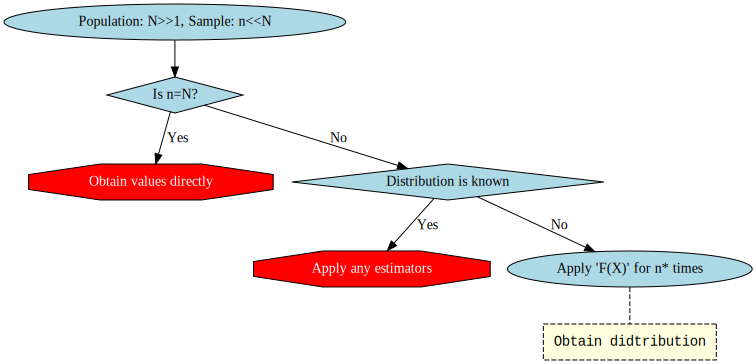

In [2]:
from flowgiston import *
Base = flowgiston_base(fillcolor='lightblue')
class Yes(Base):
    fillcolor = 'Red'
    fontcolor = 'white'
    shape = 'octagon'

class Note(Base):
    fillcolor = 'lightyellow'
    style = 'filled,dashed'
    shape = 'box'
    fontname = 'courier'

chart = FlowgistonChart(Base)

sample = chart.start("Population: N>>1, Sample: n<<N").edge(chart.if_("Is n=N?"))
sample.yes(chart.Yes.node("Obtain values directly"))
distribution = sample.no(chart.if_("Distribution is known"))
distribution.yes(chart.Yes.node("Apply any estimators"))
end = distribution.no(chart.end("Apply 'F(X)' for n* times")).edge(chart.Note.node("Obtain didtribution"), style='dashed', dir='none')
chart

Рассмотрим пример. Нам нужно найти распределение следующего параметра:
$$\frac{\overline{x}-\mu}{\frac{S}{\sqrt{n}}}.$$

Исходя из приведённой выше схемы, мы вынуждены отказаться от прямого оценивания. Тогда мы можем выбирать между классическим статистическим подходом и выборкой. Первый требует, чтобы мы знали распределение. Или мы можем сделать некоторые предположения о распределении. Например, мы можем предположить, что оцениваемая характеристика имеет нормальное распределение в генеральной совокупности. Тогда наш параметр будет иметь **t-распределение**. Но у нас нет ответа на вопрос, что произойдёт, если наши предположения окажутся неверными.

В оценочной практике мы почти всегда не знаем распределение признака на рынке и не можем сделать надёжные предположения о нём. В этом случае нам может помочь бутстрап. Идея заключается в следующем. У нас есть только одна выборка. Поэтому мы можем получить только точечную оценку параметра. Но если бы мы смогли получить некоторое количество выборок из генеральной совокупности, то смогли бы получить и распределение параметра в них. Это, в свою очередь, позволило бы нам получить доверительные интервалы параметра, независимо от каких-либо предположений. На практике мы не можем получить новые выборки без потерь в их размере. Но мы можем смоделировать новые псевдо-выборки, как если бы мы могли получить некоторые выборки из популяции.

Если наша выборка достаточно велика, то её распределение в некоторой степени является отражением распределения в генеральной совокупности. Этот факт позволяет нам сделать важный шаг в понимании концепции бутстрапа, а также общей концепции повторной выборки. Классический статистический подход опирается на предварительное предположение о форме распределения в генеральной совокупности. Методы повторной выборки, с другой стороны, предполагают, что распределение в генеральной совокупности приблизительно такое же, как и распределение выборки. В более общем смысле можно сказать, что метод предполагает работу с выборкой так, как если бы это была генеральная совокупность. Мы берём выборку и предполагаем, что она отражает распределение генеральной совокупности. Затем мы применяем некоторые методы повторной выборки. Затем мы используем функцию для расчёта интересующей нас статистики. В результате мы распространяем выводы, сделанные на основе выборки, на всю популяцию. Описанная техника выглядит немного рекурсивной. Однако на практике она работает очень хорошо.

### Техника бутстрапа

#### Получение доверительных интервалов

Рассмотрим простой случай, более продвинутый вариант которого будет полезен для нашей основной задачи. У нас есть выборка $X[x_{1}\ldots x_{n}]$ и мы хотим найти доверительный интервал для среднего значения. Конечно, нам не составит труда вычислить среднее значение выборки. Однако это всего лишь одно число, относящееся только к самой выборке. Классический подход говорит нам, что мы можем получить доверительный интервал из этого значения. Но только если известно распределение. На практике мы не имеем представления об истинном распределении на рынке. Поэтому весьма вероятно, что рассчитанный доверительный интервал будет вводить в заблуждение. Вместо этого мы предположим, что выборка достаточно репрезентативна и в какой-то степени отражает истинное распределение в популяции. Далее мы предпримем следующие шаги.
1. Мы берём нашу выборку и выполняем случайную повторную выборку с заменой для создания новой выборки того же размера. Это означает, что одно или несколько наблюдений из исходной выборки могут повторяться в новой выборке любое количество раз.
1. Повторите предыдущий шаг не менее тысячи раз. Чем больше раз вы повторите этот процесс, тем лучше будет результат. Таким образом, верхний предел повторений задаётся только вычислительной мощностью.
1. Введём некоторые новые обозначения и обозначим новую выборку как $X^{*}$. Итак, теперь у нас есть набор выборок $X^{*}$ от $X_{1}^{*}$ до $X_{B}^{*}$.
1. Вычислите интересующую вас статистику для каждого $X^{*}$. В нашем случае это будет среднее значение. Это даст нам набор значений $\overline{X_{1}^{*}},\ldots,\overline{X_{B}^{*}}$.
1. Легко увидеть, что теперь у нас есть распределение интересующей нас статистики. Это позволяет нам работать с ним так же, как и с любым другим известным распределением. Например, мы можем установить интересующие нас квантили и вычислить доверительный интервал, что и было нашей первоначальной целью.

Приведённый выше алгоритм позволяет нам обеспечить реализацию **перцентильного бутстрапа**. Это самый простой и интуитивно понятный тип бутстрапа. Но у него есть некоторые ограничения. Главное из них заключается в том, что эта техника может хорошо работать только с симметричными распределениями. Более сложным, но и более универсальным методом является **базовый бутстрап**. Этот подход использует немного другую технику. У него те же первые два шага. Но на третьем этапе мы вычисляем другую статистику:$\overline{X} - \overline{X_{i}^{*}}$. В результате мы получаем распределение следующей статистики:
$$\overline{X} - \overline{X_{i}^{*}}.$$
Его основная идея заключается в том, что благодаря очень большому количеству повторных выборок мы должны добиться следующего 
$$\mu - \overline{X} \approx \overline{X} - \overline{X^{*}}.$$
Обозначим распределение $\mu - \overline{X}$ как $\beta$. Если бы мы знали альфу, мы могли бы получить её квантили, например $\beta_{0.025}, \beta_{0.975}$. Это означает, что мы можем оценить вероятность следующего:
$$
P\left(\mu-(\overline{x}) \in [\beta_{0.025}, \beta_{0.975}]\right).
$$
Конечно, для известной беты вероятность равна 0,95. Предыдущее уравнение можно переписать следующим образом:
$$\begin{cases}
\mu-\overline{x} \leq \beta_{0.975}\\
\mu-\overline{x} \geq \beta_{0.025}.
\end{cases}
$$
Это даёт нам знание, что
$$
P\left(\mu \in [\beta_{0.025}+\overline{x}, \beta_{0.975}++\overline{x}]\right).
$$
Таким образом, мы получаем распределение популяции методом аппроксимации бутстрапом и оцениваем доверительные интервалы.

#### Проверка гипотез

Универсальность бутстрапа заключается в том, что он позволяет не только получить статистику, но и проверить гипотезы. Рассмотрим пример. Пусть у нас есть две выборки: $X=x_{1},\ldots,x_{n}$ и $Y=y_{1},\ldots,y_{m}$. И мы хотим проверить, равны ли ожидания X и Y: $\mu_{X}=\mu_{Y}\ -\ ?$. Однако все, что мы можем получить, это выборочные средние. Известный **t-тест** может справиться с этой задачей, но он также имеет известное ограничение. Он основан на предположении о нормальном распределении признака в обеих выборках. Однако наше распределение неизвестно. Преодолеть это ограничение нам поможет бутстрап. Основной подход такой же, как и в классической статистике. Мы строим нулевую и альтернативную гипотезы. Затем мы оцениваем распределение результирующей статистики для случая, когда нулевая гипотеза верна. Но сами гипотезы несколько экзотичны. Нулевая гипотеза заключается в том, что распределения *X* и *Y* равны.
1. Объедините две выборки в одну, сохранив данные о происхождении каждого наблюдения.
1. Создать новую выборку размером *m+n* путем повторной выборки с заменой.
1. Разделите её на две выборки по признаку происхождения.
1. Рассчитайте $\overline{X_{i}^{*}}$ и $\overline{Y_{j}^{*}}$.
1. Вычтите $\overline{Y_{j}^{*}}$ из $\overline{X_{i}^{*}}$.
1. Повторите шаги со 2 по 5 *k* раз *(k>1000)*.
1. Теперь у нас есть распределение разностей между $X^{*}$ и $Y^{*}$.
1. Теперь нам нужно вычесть Y из X и найти вероятность *(p-value)* такой разницы для нашего распределения, полученного на предыдущем шаге.
1. Далее мы сравниваем p-значение с $\alpha$ (наиболее распространённым является 0.05) и принимаем решение, отвергать ли нулевую гипотезу. 

Последние два шага ничем не отличаются от классического подхода к проверке гипотез.

### Типы методов бутстраппинга

Существует множество способов бутстрапа. Сегодня мы рассмотрим только три, которых должно быть достаточно для первого погружения оценщика в машинное обучение.

#### Базовый бутстрап

##### Основные положения

Базовый бутстрап — это статистический метод оценки распределения выборочной статистики, такой как среднее значение или стандартное отклонение, по одной выборке данных. Базовый метод бутстрапа предполагает повторную выборку исходной выборки с заменой для создания множества имитированных выборок, вычисление интересующей статистики для каждой имитированной выборки. А затем с помощью распределения этих смоделированных статистик оценивается распределение интересующей статистики.

Ниже приводится пошаговое описание базового метода бутстрапа.
1. Возьмите случайную выборку размером *n* из интересующей вас популяции.
1. Возьмите множество случайных выборок размером *n* из исходной выборки с заменой. Это означает, что для каждой выборки случайным образом выбирается *n* наблюдений из исходной выборки, причем каждое наблюдение может быть выбрано более одного раза.
1. Для каждой смоделированной выборки вычислите интересующую статистику (например, среднее значение или стандартное отклонение).
1. Оцените распределение интересующей статистики способом вычисления среднего, стандартного отклонения или доверительных интервалов смоделированной статистики.

Основной метод бутстрапа полезен, когда у вас небольшой объём выборки или когда вы не можете предположить, что популяция нормально распределена. Его можно использовать для оценки неопределённости, связанной со статистикой выборки, для сравнения различных групп или условий, а также для проверки гипотез о популяции.

Важно отметить, что базовый метод бутстрапа предполагает, что исходная выборка является репрезентативной для интересующей нас популяции и что наблюдения выборки являются независимыми и одинаково распределёнными. Если эти предположения не выполняются, результаты бутстрапа могут быть неточными.

##### Преимущества и недостатки

**Преимущества** базового бутстрапа.
1. Непараметрический: базовый метод бутстрапа не делает никаких предположений о распределении совокупности, поэтому он является непараметрическим методом. Это делает его полезным инструментом для анализа данных, которые могут не соответствовать нормальному распределению.
1. Гибкость: базовый метод бутстрапа может быть применен к широкому спектру статистических данных, таких как средние значения, дисперсии и отношения. Это делает его универсальным инструментом для решения многих типов исследовательских вопросов.
1. Размер выборки: базовый метод бутстрапа особенно полезен, когда объём выборки невелик. Генерируя множество выборок из исходных данных, метод позволяет получить более точные оценки параметров совокупности.
1. Доверительные интервалы: базовый метод бутстрапа может быть использован для оценки доверительных интервалов для параметров популяции, что может помочь количественно оценить неопределённость, связанную с оценками.

**Недостатки** базового бутстрапа.
1. Вычислительные затраты: базовый метод бутстрапа требует генерации множества повторных выборок, что может быть вычислительно интенсивным и отнимать много времени, особенно для действительно больших наборов данных.
1. Смещение: базовый метод бутстрапа может давать смещённые оценки, если исходная выборка не является репрезентативной для популяции. Это может привести к неточным оценкам её параметров.
1. Зависимость данных: Основной метод бутстрапа предполагает, что наблюдения в исходной выборке являются независимыми и одинаково распределёнными. Если это предположение не выполняется, результаты бутстрапа могут быть неточными.
1. Точность: Точность базового метода бутстрапа зависит от количества сгенерированных повторных выборок. Если число повторных выборок слишком мало, результаты могут быть недостоверными. Однако генерирование большого количества повторных выборок может потребовать больших вычислительных затрат, как уже упоминалось выше.

#### Сглаженный бустрап

##### Основные положения

Одна из проблем базового бутстрапа заключается в том, что он может давать оценки, которые слишком изменчивы или неустойчивы, особенно когда размер выборки мал или распределение данных сильно перекошено или имеет тяжёлые хвосты. Сглаженный бутстрап – это модификация базового бутстрапа, которая решает эту проблему путем добавления шага сглаживания в процесс повторной выборки.

В сглаженном бутстрапе вместо того, чтобы делать выборку непосредственно из исходного набора данных, мы сначала подгоняем функцию плотности вероятности (PDF) к данным с помощью ядерной оценки плотности (KDE) или аналогичного метода. Затем мы берём выборку из этой PDF для создания бутстрап-выборок, а не напрямую берём выборку из исходного набора данных. Это даёт эффект "сглаживания" распределения и может помочь уменьшить изменчивость оценок бутстрапа.

Один из распространённых подходов к реализации сглаженного бутстрапа заключается в использовании алгоритма повторной выборки следующим образом.
1. Подгоните функцию плотности вероятности к исходным данным с помощью ядерной оценки плотности или аналогичного метода.
1. Сгенерируйте множество бутстрап-выборок путем выборки из PDF, а не из данных непосредственно.
1. Вычислите интересующую статистику для каждой из этих бутстрап-выборок.
1. Вычислите среднее значение, медиану, доверительный интервал и т.п. для полученных бутстрап-оценок, чтобы получить окончательную оценку статистики.

Шаг сглаживания можно отрегулировать, чтобы сбалансировать соотношение погрешности и дисперсии в процедуре оценки. Более высокая степень сглаживания приводит к более смещённой оценке, но с меньшей дисперсией, в то время как более низкая степень сглаживания приводит к менее смещённой оценке, но с большей дисперсией. Выбор параметра сглаживания зависит от конкретного применения и характеристик данных.

##### Преимущества и недостатки

**Преимущества** сглаженного бутстрапа.
1. Снижение изменчивости: основное преимущество сглаженного бутстрапа заключается в том, что он может уменьшить изменчивость оценок бутстрапа по сравнению с базовым бутстрапом. Это особенно полезно, когда объём выборки мал или распределение данных сильно перекошено или имеет большие хвосты.
1. Более точные оценки: шаг сглаживания в сглаженном бутстрапе также может помочь получить более точные оценки базового распределения данных, особенно в тех случаях, когда истинное распределение неизвестно или его трудно оценить.
1. Гибкость: сглаженный бутстрап является гибким и может быть адаптирован к различным типам данных и статистических моделей. Его также можно использовать для оценки распределения более сложных статистических данных, таких как квантили или коэффициенты регрессии.

**Недостатки** сглаженного бутстрапа.
1. Сдвиг: шаг сглаживания в сглаженном бутстрапе может вносить смещение в оценки, особенно если параметр сглаживания установлен слишком высоким. Это смещение может быть трудно оценить количественно и скорректировать.
1. Сложность: сглаженный бутстрап может быть более ресурсоёмким в вычислениях, чем основной бутстрап, особенно если этап сглаживания включает в себя подгонку сложной модели или оценку множества параметров.
1. Зависимость от параметра сглаживания: выбор параметра сглаживания в сглаженном бутстрапе может оказать значительное влияние на качество оценок. Поиск оптимального параметра сглаживания может быть сложным и может потребовать дополнительных шагов настройки или валидации.
1. Возможная потеря информации: шаг сглаживания в сглаженном бутстрапе может также привести к потере информации о базовом распределении данных. Это может затруднить выводы об истинном распределении или обнаружение таких особенностей, как выбросы или бимодальность.

#### Байесовский бутстрап

##### Основные положения

Байесовский бутстрап – это метод повторной выборки, используемый в Байесовском выводе, который можно использовать для оценки апостериорного распределения параметра или модели. Как и другие методы бутстрапа, Байесовский бутстрап предполагает генерацию многочисленных выборок из данных, но это делается в байесовском контексте.

В Байесовском бутстрапе мы предполагаем, что данные получены из некоторого неизвестного распределения, которое может быть описано априорным распределением и функцией правдоподобия. Затем мы моделируем новые наборы данных путём повторной выборки из исходного набора данных, но вместо простой выборки данных с заменой, мы также проводим повторную оценку априорного распределения.

Более конкретно, алгоритм Байесовского бутстрапа может быть обобщён следующим образом.
1. Определите априорное распределение для неизвестного параметра(ов) или модели.
1. Вычислите функцию правдоподобия данных с учётом параметра(ов) или модели.
1. Выборка нового предварительного распределения путем повторной выборки из исходного априорного распределения.
1. Выборка нового набора данных путём повторной выборки из исходного набора данных.
1. Вычислите апостериорное распределение параметра(ов) или модели, используя новое априорное распределение и функцию правдоподобия на основе нового набора данных.
1. Повторите шаги 3-5 для создания множества смоделированных апостериорных распределений.

Полученные апостериорные распределения можно использовать для оценки среднего, дисперсии и других характеристик истинного апостериорного распределения, а также для вероятностных утверждений о параметре (параметрах) или модели.

Одним из преимуществ Байесовского бутстрапа является то, что он может использоваться с широким диапазоном предшествующих распределений и функций правдоподобия, что делает его универсальным инструментом для Байесовского вывода. Его также можно использовать для оценки апостериорного распределения сложных моделей, которые не поддаются аналитическому решению, и он не требует никаких предположений о форме базового распределения или наличии выбросов. Однако, как и другие методы повторной выборки, Байесовский бутстреп требует больших вычислительных затрат и может потребовать многочисленных симуляций для получения точных оценок апостериорного распределения.

##### Преимущества и недостатки

**Преимущества** Байесовского бутстрапа.
1. Гибкость: Байесовский бутстрап — это гибкий метод, который можно применять к широкому спектру статистических моделей и априорных распределений. Это делает его полезным во многих ситуациях, где другие методы могут быть неприменимы.
1. Отсутствие предположений о базовом распределении: в отличие от некоторых других методов, Байесовский бутстрап не требует никаких предположений о форме базового распределения или наличии выбросов.
1. Предоставляет полное апостериорное распределение: Байесовский бутстрап предоставляет полное апостериорное распределение неизвестного параметра(ов) или модели, а не просто точечную оценку. Это позволяет получить более полное представление о неопределённости, связанной с оценкой.
1. Работает со сложными моделями: Байесовский бутстрап можно использовать для оценки апостериорного распределения сложных моделей, которые не поддаются аналитическому решению.

**Недостатки** Байесовского бутстрапа.
1. Вычислительные затраты: Байесовский бутстрап может быть вычислительно интенсивным, особенно для больших наборов данных или сложных моделей. Это может сделать его непрактичным в некоторых ситуациях, когда другие методы могут быть быстрее.
1. Может быть чувствителен к выбору априорного распределения: Байесовский бутстрап зависит от выбора априорного распределения. Выбор априорного распределения может повлиять на результаты анализа, поэтому важно тщательно выбирать априорное распределение, подходящее для изучаемой проблемы.
1. Может плохо работать при малых объёмах выборки: Байесовский бутстрап может быть чувствителен к малым объёмам выборки, и в ситуациях, когда объём выборки очень мал, он может работать не так хорошо, как другие методы.
1. Требует некоторого понимания Байесовского вывода: Байесовский бутстрап является методом в рамках Байесовского вывода и требует некоторого понимания Байесовских принципов и концепций для эффективного использования. Это может ограничить его применение в некоторых областях или приложениях, где пользователи не знакомы с Байесовскими методами.

## Практическая реализация

### Общие вопросы

Вернёмся к нашей задаче обучения и вычислим истинные значения на рынке, чтобы помочь банку разработать свою кредитную политику. Мы будем использовать реальный набор данных с 2355 наблюдениями на одном из рынков. Сегодня у нас есть два интересующих нас столбца: 'price' и 'price_m'. Первый содержит данные о ценах на сами объекты недвижимости, а второй — об их ценах за квадратный метр. На первом этапе мы выполняем некоторые технические действия и вычисляем оценки выборки.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
from scipy.stats import norm
from scipy.stats import scoreatpercentile

# limitation of digits
# pd.set_option('display.float_format', lambda x: f'{x:.5f}')
# np.set_printoptions(precision=5)

In [3]:
# create function for easy calculation of sample standard deviation
def appr_sam_std(a, ddof = 1):
    return np.std(a, ddof = ddof)

In [4]:
# import data
data = pd.read_csv("ds.csv", index_col=False)

# calculate statistics for the "general population"
tp_sample_mean   = data['price'].mean()
up_sample_mean   = data['price_m'].mean()
tp_sample_std    = data['price'].std()
up_sample_std    = data['price_m'].std()
formatted_tp_sample_mean = '{:.2f}'.format(tp_sample_mean)
formatted_up_sample_mean = '{:.2f}'.format(up_sample_mean)
formatted_tp_sample_std = '{:.2f}'.format(tp_sample_std)
formatted_up_sample_std = '{:.2f}'.format(up_sample_std)
print("The sample mean price is", formatted_tp_sample_mean)
print("The sample mean unit price is", formatted_up_sample_mean)
print("The sample standard deviation of price is", formatted_tp_sample_std)
print("The sample standard deviation of unit price is", formatted_up_sample_std)

The sample mean price is 23372356.69
The sample mean unit price is 361554.02
The sample standard deviation of price is 16061866.51
The sample standard deviation of unit price is 95947.20


Теперь мы можем перейти к бутстрапу. Для этого существуют некоторые библиотечные функции, но сегодня мы создадим свои собственные функции, чтобы лучше понять природу техники. Мы создадим и реализуем функции для следующих типов бутстрапа:
1. базовый бутстрап;
1. сглаженный бутстрап;
1. Байесовский бутстрап.

Не существует единственного "лучшего" типа бутстрапинга, поскольку выбор метода зависит от конкретной задачи и целей анализа. Базовый бутстрап и перцентильный бутстрап — два наиболее часто используемых метода, но существуют и другие варианты бутстрапа, такие как бутстрап с коррекцией смещения и ускорением (BCa) и бутстрап со стьюдентизированной выборкой.

Базовый бутстрап — самый простой и понятный метод, поскольку он предполагает многократную выборку из исходных данных с заменой и вычисление интересующей статистики на каждой бутстрап-выборке. Этот метод обычно подходит для оценки выборочного распределения простых статистик, таких как среднее значение или дисперсия, и относительно прост в применении.

Перцентильный бутстрап — это более сложный метод, который предполагает вычисление доверительного интервала интересующей статистики с использованием эмпирических перцентилей бутстрап-распределения. Этот метод в основном предпочтителен, когда выборочное распределение статистики ненормально или размер выборки мал, поскольку он обеспечивает более точные доверительные интервалы и менее чувствителен к основному распределению данных.

Бутстрап BCa - это вариант перцентильного бутстрапа, который корректирует смещение и ассиметрию в распределении бутстрапа. В основном он более точен, чем основной и перцентильный бутстрап для небольших выборок или когда базовое распределение сильно скошено. Однако он может быть более трудоёмким в вычислениях и требует более глубоких статистических знаний для реализации.

Бутстреп со стюдентизацией — это метод, который предполагает стандартизацию интересующей статистики путём использования её оценённой стандартной ошибки, а затем повторную выборку из t-распределения со степенями свободы, равными размеру выборки минус один. Этот метод обычно предпочтителен, когда интересующая статистика представляет собой отношение или разность двух оценок, или когда распределение статистики сильно перекошено или имеет тяжёлые хвосты.

В целом, выбор типа бутстрапа зависит от конкретной проблемы и целей анализа, а также от доступных вычислительных ресурсов и статистического опыта аналитика. Часто бывает полезно сравнить результаты нескольких методов бутстрапа, чтобы убедиться, что выводы надёжны и не слишком чувствительны к выбору метода.

### Базовый бустрап

Код, приведённый ниже, определяет функцию 'appr_basic_bootstrap', которая выполняет базовый бутстрап на наборе данных для вычисления статистики и её доверительных интервалов с использованием асимптотического метода.

Функция принимает пять аргументов:
1. *data*: входной набор данных в виде массива;
1. *num_samples*: количество бутстрап-выборок для генерации;
1. *sample_size*: размер каждой бутстрап-выборки, по умолчанию равен размеру входного набора данных;
1. *stat_func*: статистика для расчёта на каждой бутстрап-выборке, по умолчанию — среднее значение;
1. *ci*: доверительный интервал для расчёта, по умолчанию 95%.

Сначала функция проверяет, является ли *sample_size* значением None, если да, то устанавливает *sample_size* равным длине данных. Затем вычисляется *original_statistic* путём применения функции *stat_func* к входным данным. Затем она генерирует *num_samples* бутстрап-выборок размера *sample_size* путём случайного выбора элементов из данных с заменой с помощью **np.random.choice**.

Она вычисляет *stat_func* для каждой бутстрап-выборки с помощью **np.apply_along_axis** и сохраняет полученные значения в *bootstrap_statistics*. Затем вычисляется среднее значение всех значений *stat_func* из бутстрап-выборок, чтобы получить *bootstrap_statistic*.

Наконец, она рассчитывает значения *ci_lower* и *ci_upper* для доверительного интервала с помощью **scipy.stats.scoreatpercentile** со значениями *alpha (100 - ci) / 2* и *100 - (100 - ci) / 2*, соответственно.

Функция возвращает кортеж, содержащий **'bootstrap_statistic'**, **'ci_lower'** и **'ci_upper'**.

In [5]:
def appr_basic_bootstrap(data, stat_func=np.mean, num_samples=2000, sample_size=None, ci=95):
    """
    Perform basic bootstrap on a dataset to calculate a statistic and its confidence intervals.

    Parameters:
        data (array-like): The input dataset.
        num_samples (int): The number of bootstrap samples to generate.
        sample_size (int): The size of each bootstrap sample. Defaults to the size of the input dataset.
        stat_func (function): The statistic to calculate on each bootstrap sample. Defaults to the mean.
        ci (int): The confidence interval to calculate. Defaults to 95%.

    Returns:
        A tuple containing the calculated statistic and its confidence interval.
    """
    if sample_size is None:
        sample_size = len(data)

        
    # Calculate the statistic on the original dataset
    original_statistic = stat_func(data)    
        
    # Generate bootstrap samples
    bootstrap_samples = np.random.choice(data, size=(num_samples, sample_size), replace=True)

    # Calculate the statistic on each bootstrap sample
    bootstrap_statistics = np.apply_along_axis(stat_func, axis=1, arr=bootstrap_samples)
    
    # Calculate the mean of all statistic's values
    bootstrap_statistic = np.mean(bootstrap_statistics)
    
    # Calculate the confidence interval
    alpha = (100 - ci) / 2
    ci_lower = scoreatpercentile(bootstrap_statistics, alpha)
    ci_upper = scoreatpercentile(bootstrap_statistics, 100 - alpha)

    return bootstrap_statistic, ci_lower, ci_upper

Теперь давайте применим её к нашим данным.

In [6]:
# apply the 'appr_basic_bootstrap' function to data
tp_basic_bootstrap_mean = appr_basic_bootstrap(data['price'])
tp_basic_bootstrap_std  = appr_basic_bootstrap(data['price'], stat_func = appr_sam_std)
up_basic_bootstrap_mean = appr_basic_bootstrap(data['price_m'])
up_basic_bootstrap_std  = appr_basic_bootstrap(data['price_m'], stat_func = appr_sam_std)

# extract single balues from tuple
tp_basb_mean, tp_basb_mean_lowCI, tp_basb_mean_upperCI = tp_basic_bootstrap_mean
tp_basb_std, tp_basb_std_lowCI, tp_mean_basb_upperCI = tp_basic_bootstrap_std
up_basb_mean, up_basb_mean_lowCI, up_basb_mean_upperCI = up_basic_bootstrap_mean
up_basb_std, up_basb_std_lowCI, up_mean_basb_upperCI = up_basic_bootstrap_std


# output the result to the user
print(f'The mean price obtained by the basic bootstrap is {tp_basb_mean:.2f} \
with 95% confidence interval [{tp_basb_mean_lowCI:.2f}, {tp_basb_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the basic bootstrap is {tp_basb_std:.2f} \
with 95% confidence interval [{tp_basb_std_lowCI:.2f}, {tp_mean_basb_upperCI:.2f}].')
print(f'The mean unit price obtained by the basic bootstrap is {up_basb_mean:.2f} \
with 95% confidence interval [{up_basb_mean_lowCI:.2f}, {up_basb_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the basic bootstrap is {up_basb_std:.2f} \
with 95% confidence interval [{up_basb_std_lowCI:.2f}, {up_mean_basb_upperCI:.2f}].')

The mean price obtained by the basic bootstrap is 23370941.70 with 95% confidence interval [22727684.71, 24033931.00].
The standard deviation of the price obtained by the basic bootstrap is 16020188.92 with 95% confidence interval [14191560.87, 18008702.41].
The mean unit price obtained by the basic bootstrap is 361566.09 with 95% confidence interval [357732.73, 365501.65].
The standard deviation of the unit price obtained by the basic bootstrap is 95885.97 with 95% confidence interval [91171.64, 100680.84].


### Сглаженный бутстрап

Мы определяем функцию **smoothed_bootstrap**, которая принимает на вход данные, интересующую статистическую функцию, желаемый уровень доверительного интервала и количество бутстрап-выборок для генерации. Функция возвращает сглаженную бутстреп-оценку статистики, а также нижнюю и верхнюю границы доверительного интервала.

In [29]:
def appr_smoothed_bootstrap(data, statistic_func, alpha=0.05, n_bs_samples=2000):
    """
    Computes the smoothed bootstrap estimate and confidence intervals for a given statistic.
    
    Args:
    - data (array-like): the data from which to compute the statistic and confidence intervals
    - statistic_func (function): the function to compute the statistic of interest
    - alpha (float): the desired level of confidence interval (default 0.05)
    - n_bs_samples (int): the number of bootstrap samples to generate (default 1000)
    
    Returns:
    - bs_statistic (float): the smoothed bootstrap estimate of the statistic
    - ci_low (float): the lower bound of the confidence interval
    - ci_high (float): the upper bound of the confidence interval
    """
    
    # Compute the observed statistic
    obs_statistic = statistic_func(data)
    
    # Generate the bootstrap samples
    bs_samples = np.random.choice(data, size=(len(data), n_bs_samples))
    
    # Compute the bootstrap statistics
    bs_statistics = np.apply_along_axis(statistic_func, axis=0, arr=bs_samples)
    
    # Compute the standard deviation of the bootstrap statistics
    bs_std = np.std(bs_statistics)
    
    # Compute the smoothed bootstrap weights
    bs_weights = norm.pdf(bs_statistics - obs_statistic, scale=bs_std)
    
    # Compute the smoothed bootstrap estimate of the statistic
    bs_statistic = np.average(bs_statistics, weights=bs_weights)
    
    # Compute the confidence intervals
    bs_statistics_sorted = np.sort(bs_statistics)
    ci_low = bs_statistics_sorted[int(np.floor((alpha/2) * n_bs_samples))]
    ci_high = bs_statistics_sorted[int(np.ceil((1 - alpha/2) * n_bs_samples))]
    
    return bs_statistic, ci_low, ci_high


Применение к данным.

In [35]:
# apply the 'appr_smoothed_bootstrap' function to data
tp_smoothed_bootstrap_mean = appr_smoothed_bootstrap(data['price'], statistic_func = np.mean)
tp_smoothed_bootstrap_std  = appr_smoothed_bootstrap(data['price'], statistic_func = appr_sam_std)
up_smoothed_bootstrap_mean = appr_smoothed_bootstrap(data['price_m'], statistic_func = np.mean)
up_smoothed_bootstrap_std  = appr_smoothed_bootstrap(data['price_m'], statistic_func = appr_sam_std)

# extract single balues from tuple
tp_smob_mean, tp_smob_mean_lowCI, tp_smob_mean_upperCI = tp_smoothed_bootstrap_mean
tp_smob_std, tp_smob_std_lowCI, tp_mean_smob_upperCI = tp_smoothed_bootstrap_std
up_smob_mean, up_smob_mean_lowCI, up_smob_mean_upperCI = up_smoothed_bootstrap_mean
up_smob_std, up_smob_std_lowCI, up_mean_smob_upperCI = up_smoothed_bootstrap_std

# output the result to the user
print(f'The mean price obtained by the smoothed bootstrap is {tp_smob_mean:.2f} \
with 95% confidence interval [{tp_smob_mean_lowCI:.2f}, {tp_smob_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the smoothed bootstrap is {tp_smob_std:.2f} \
with 95% confidence interval [{tp_smob_std_lowCI:.2f}, {tp_mean_smob_upperCI:.2f}].')
print(f'The mean unit price obtained by the smoothed bootstrap is {up_smob_mean:.2f} \
with 95% confidence interval [{up_smob_mean_lowCI:.2f}, {up_smob_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the smoothed bootstrap is {up_smob_std:.2f} \
with 95% confidence interval [{up_smob_std_lowCI:.2f}, {up_mean_smob_upperCI:.2f}].')

The mean price obtained by the smoothed bootstrap is 23376253.48 with 95% confidence interval [22768577.49, 23979150.74].
The standard deviation of the price obtained by the smoothed bootstrap is 16001329.71 with 95% confidence interval [14269520.65, 17909150.10].
The mean unit price obtained by the smoothed bootstrap is 361538.07 with 95% confidence interval [357495.87, 365667.21].
The standard deviation of the unit price obtained by the smoothed bootstrap is 95940.75 with 95% confidence interval [91305.76, 100445.92].


### Байесовский бутстрап

Приведенная ниже функция принимает шесть необходимых аргументов:
1. *X*, представляющий собой массив данных, который вы хотите повторно сэмплировать;
1. *stat_func* - функция, которую нужно применить к каждому набору данных для вычисления нужной статистики (по умолчанию np.mean);
1. *num_samples* - количество бутстрап-выборок, которые необходимо сгенерировать (по умолчанию 2000);
1. *alpha* - уровень значимости для доверительного интервала (по умолчанию 0,05);
1. *low_mem* задает способ генерации весов (по умолчанию False);
1. *resample_size* задает размер повторной выборки (по умолчанию None).

Сначала функция вычисляет эмпирическую функцию распределения (EDF) данных, которая используется для генерации выборок Байесовского бутстрапа. Затем она применяет статистическую функцию к каждой бутстрап-выборке и вычисляет байесовскую бутстрап-оценку статистики, беря среднее значение бутстрап-статистик. Наконец, она вычисляет (1-alpha) доверительный интервал, находя соответствующие процентили статистики бутстрепа. Данная функция является лишь небольшим расширением функции [bayesian_bootstrap](https://github.com/lmc2179/bayesian_bootstrap) (Луиса Сиалделлы) (https://github.com/lmc2179).

In [36]:
def appr_bayesian_bootstrap(X, statistic=np.mean, n_replications=2000, resample_size=None, low_mem=False, alpha=0.05):
    """Simulate the posterior distribution of the given statistic.

    Parameter X: The observed data (array like)

    Parameter statistic: A function of the data to use in simulation (Function mapping array-like to number)

    Parameter n_replications: The number of bootstrap replications to perform (positive integer)

    Parameter resample_size: The size of the dataset in each replication
    
    Parameter low_mem(bool): Generate the weights for each iteration lazily instead of in a single batch. Will use
    less memory, but will run slower as a result.

    Returns: Statistoc for the samples from the posterior
    """
    
    if resample_size is None:
        resample_size = len(X)
    
    if isinstance(X, list):
        X = np.array(X)
    samples = []
    if low_mem:
        weights = (np.random.dirichlet([1] * len(X)) for _ in range(n_replications))
    else:
        weights = np.random.dirichlet([1] * len(X), n_replications)
    for w in weights:
        sample_index = np.random.choice(range(len(X)), p=w, size=resample_size)
        resample_X = X[sample_index]
        s = statistic(resample_X)
        samples.append(s)
        
    samples_sorted = sorted(samples)
    window_size = int(len(samples) - round(len(samples)*alpha))
    smallest_window = (None, None)
    smallest_window_length = float('inf')
    for i in range(len(samples_sorted) - window_size):
        window = samples_sorted[i+window_size-1], samples_sorted[i]
        window_length = samples_sorted[i+window_size-1] - samples_sorted[i]
        if window_length < smallest_window_length:
            smallest_window_length = window_length
            smallest_window = window
            
    posterior_statistic = np.mean(samples)         
            
    return posterior_statistic, smallest_window[1], smallest_window[0]

Применение к данным.

In [38]:
# apply the 'appr_bayesian_bootstrap' function to data
tp_bayesian_bootstrap_mean = appr_bayesian_bootstrap(data['price'])
tp_bayesian_bootstrap_std  = appr_bayesian_bootstrap(data['price'], statistic = np.std)
up_bayesian_bootstrap_mean = appr_bayesian_bootstrap(data['price_m'])
up_bayesian_bootstrap_std  = appr_bayesian_bootstrap(data['price_m'], statistic = np.std)

# extract single balues from tuple
tp_bayb_mean, tp_bayb_mean_lowCI, tp_bayb_mean_upperCI = tp_bayesian_bootstrap_mean
tp_bayb_std, tp_bayb_std_lowCI, tp_mean_bayb_upperCI = tp_bayesian_bootstrap_std
up_bayb_mean, up_bayb_mean_lowCI, up_bayb_mean_upperCI = up_bayesian_bootstrap_mean
up_bayb_std, up_bayb_std_lowCI, up_mean_bayb_upperCI = up_bayesian_bootstrap_std


# output the result to the user
print(f'The mean price obtained by the Bayesian bootstrap is {tp_bayb_mean:.2f} \
with 95% confidence interval [{tp_bayb_mean_lowCI:.2f}, {tp_bayb_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the Bayesian bootstrap is {tp_bayb_std:.2f} \
with 95% confidence interval [{tp_bayb_std_lowCI:.2f}, {tp_mean_bayb_upperCI:.2f}].')
print(f'The mean unit price obtained by the Bayesian bootstrap is {up_bayb_mean:.2f} \
with 95% confidence interval [{up_bayb_mean_lowCI:.2f}, {up_bayb_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the Bayesian bootstrap is {up_bayb_std:.2f} \
with 95% confidence interval [{up_bayb_std_lowCI:.2f}, {up_mean_bayb_upperCI:.2f}].')

The mean price obtained by the Bayesian bootstrap is 23373192.97 with 95% confidence interval [22497282.38, 24304543.52].
The standard deviation of the price obtained by the Bayesian bootstrap is 16014052.16 with 95% confidence interval [13464056.97, 18795443.99].
The mean unit price obtained by the Bayesian bootstrap is 361545.02 with 95% confidence interval [356060.67, 366479.47].
The standard deviation of the unit price obtained by the Bayesian bootstrap is 95910.03 with 95% confidence interval [89534.47, 103327.87].


### Применение результатов для разработки элементов кредитной политики

Все три методики дали нам схожие результаты. Поэтому мы можем без колебаний использовать любую из них. Сегодня мы будем использовать результаты байесовского бутстрапа. Апостериорное среднее и стандартное отклонение цены составляют 23373192.97 и 16014052.16 соответственно. Апостериорное среднее и стандартное отклонение цены квадратного метра составляют 361545.02 и 95910.03 соответственно. Таким образом, мы можем установить следующие правила ограничений для залогового имущества.

||Minimum limit | Maximum limit | Mean| STD|
|:-|:-|:-|:-|:-|
|Price|**6,483,230.22**|**38,511,334.54**|23,373,192.97|16,014,052.16|
|Unit price|**169,724.96**|**553,365,08**|361,545.02|95,910.03|

Использование таких лимитов может защитить банк от принятия нетипичного или неликвидного залога.

## Заключение

Сегодня мы узнали, как преодолеть две основные проблемы, с которыми оценщики сталкиваются каждый день:
1. проблема малых выборок, которые намного меньше, чем весь рынок;
2. проблема неизвестного распределения.

Бутстрап легко решает обе эти проблемы. Использование методов бутстрапа может значительно улучшить качество рыночных данных. В некотором смысле можно сказать, что его целесообразно использовать всякий раз, когда у оценщика есть хотя бы 20 или 30 наблюдений. 
Для обсуждения этой или любой другой темы, связанной с машинным обучением в оценке, приглашаю вас присоединиться к моему [сообществу в Facebook](https://www.facebook.com/groups/1977067932456703), а также [Telegram каналу](https://t.me/AIinValuation).